In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Device 설정 확인

In [2]:
# DEVICE의 출력으로 cuda가 나오는지 확인합니다.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE :', DEVICE)

DEVICE : cuda


### MNIST Dataset 준비

In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    ])

# MNIST dataset을 준비합니다. 필요시 다운로드 받습니다.
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
print(train_data)

test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


### Data Loader를 만듭니다.

In [4]:
# MNIST dataset을 트레이닝과 테스트에 사용할 수 있도록 Data Loader를 만듭니다.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024)
print('done')

done


### Encoder
*   input : image - (B, 1, 28, 28)
*   output : mean - (B, 2), logstd - (B, 2)

Encoder는 image를 입력받아 Z-space의 확률분포 $p_{\phi}(z)$의 parameter mean $\mu$와 log standard deviation $\log\sigma$를 출력합니다.


In [5]:
class EncoderConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                            out_channels=out_channels, 
                                            kernel_size=3, stride=2, padding=1), 
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(),
                                  nn.Dropout(0.2))
        
    def forward(self, x):
        
        return self.conv(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # (B, 1, 32, 32) -> (B, 8, 32, 32)
        self.prenet = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1)
        self.convs = nn.Sequential(EncoderConv(8, 16), # ->(B, 16, 16, 16)
                                   EncoderConv(16, 32), # ->(B, 32, 8, 8)
                                   EncoderConv(32, 64), # ->(B, 64, 4, 4)
                                   EncoderConv(64, 128)) # ->(B, 128, 2, 2)
        self.linears = nn.Sequential(nn.Linear(128*2*2, 64), # ->(B, 64)
                                     nn.ReLU(),
                                     nn.Linear(64, 16), # ->(B, 16)
                                     nn.ReLU())
        # -> (B, 2)
        self.mean_linear = nn.Linear(16, 2)
        # -> (B, 2)
        self.logstd_linear = nn.Linear(16, 2)

    def forward(self, x):
        # x : (B, 1, 32, 32)

        # -> (B, 8, 32, 32)
        x = self.prenet(x)
        # -> (B, 128, 2, 2)
        x = self.convs(x)
        # (B, 128*2*2)
        x = x.reshape(-1, 128*2*2)
        # (B, 64)
        x = self.linears(x)
        # (B, 2)
        z_mean = self.mean_linear(x)
        # (B, 2)
        z_logstd = self.logstd_linear(x)

        return z_mean, z_logstd

### Decoder

In [6]:
class DecoderConvT(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, 
                                                     out_channels=out_channels, 
                                                     kernel_size=2, stride=2),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU())
        
    def forward(self, x):
        
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # (B, 2) -> (B, 128*2*2)
        self.linear = nn.Sequential(nn.Linear(2, 16),
                                    nn.ReLU(),

                                    nn.Linear(16, 64),
                                    nn.ReLU(),

                                    nn.Linear(64, 128*2*2))

        self.convs = nn.Sequential(DecoderConvT(128, 64), # -> (B, 64, 4, 4)
                                   DecoderConvT(64, 32), # -> (B, 32, 8, 8)
                                   DecoderConvT(32, 16), # -> (B, 16, 16, 16)
                                   DecoderConvT(16, 8)) # -> (B, 8, 32, 32)

        # -> (B, 1, 32, 32)               
        self.postnet = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1)

    def forward(self, z):
        # z : (B, 2)

        # (B, 128*2*2)
        y = self.linear(z)
        # (B, 128, 2, 2)
        y = y.reshape(-1, 128, 2, 2)
        # -> (B, 8, 32, 32)
        y = self.convs(y)
        # (B, 1, 32, 32)
        y = self.postnet(y)

        return y

### 전체 모델

Loss Function \begin{array}{l}
\mathcal{L}\left(\boldsymbol{\theta}, \boldsymbol{\phi} ; \mathbf{x}^{(i)}\right) \simeq \frac{1}{2} \sum_{j=1}^{J}\left(1+\log \left(\left(\sigma_{j}^{(i)}\right)^{2}\right)-\left(\mu_{j}^{(i)}\right)^{2}-\left(\sigma_{j}^{(i)}\right)^{2}\right)+\frac{1}{L} \sum_{l=1}^{L} \log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}^{(i, l)}\right) \\
\text { where } \mathbf{z}^{(i, l)}=\boldsymbol{\mu}^{(i)}+\boldsymbol{\sigma}^{(i)} \odot \boldsymbol{\epsilon}^{(l)} \quad \text { and } \quad \boldsymbol{\epsilon}^{(l)} \sim \mathcal{N}(0, \mathbf{I})
\end{array}

In [7]:

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
    
    # Variational posterior q(z)에서 샘플을 하나 뽑습니다. 
    # Reparameterization Trick이 사용되는 것을 주목합니다.
    def _sample(self, z_mean, z_logstd):
        # z_mean : (B, 2)
        # z_logstd : (B, 2)

        # (B, 2)
        epsilon = torch.randn(*z_logstd.shape).cuda()
        z_sample = z_mean + epsilon * z_logstd.exp()

        return z_sample

    # 전체 loss function을 구합니다. 
    # Reconstruction loss와 regularization loss로 구성되어있습니다.
    # Reconstruction loss는 z sample이 주어졌을 때의 negative log-likelihood인 -log(x|z)를 최소화 합니다.
    # p(x|z)를 Gaussian distribution으로 설정한 경우, output y와 input x의 MSE loss를 최소화하는 것은
    # output y가 Gaussian distribution의 mean이 되게 합니다.
    # Regularization loss는 variational posterior q(z|x)와 prior p(z) 간의 KL-divergence입니다.
    # 두 Gaussian distribution간의 KL-div.는 closed-form으로 구할 수 있습니다.
    def loss_function(self, x, y, z_mean, z_logstd):
        # x : (B, 1, 28, 28)
        # y : (B, 1, 28, 28)
        # z_mean : (B, 2)
        # z_logstd : (B, 2)

        # (B)
        reconstruction_loss = torch.sum((x - y) ** 2, dim=[1, 2, 3])
        # (B)
        regularization_loss = -0.5 * torch.sum(1 + 2*z_logstd - z_mean**2 - z_logstd.exp()**2, dim=1)
        # scalar
        loss = torch.mean(reconstruction_loss + regularization_loss)

        return loss

    def forward(self, x):
        # x : (B, 1, 28, 28)

        # z_mean : (B, 2), z_logstd : (B, 2)
        z_mean, z_logstd = self.encoder(x)
        # (B, 2)
        z_sample = self._sample(z_mean, z_logstd)
        # (B, 1, 28, 28)
        y = self.decoder(z_sample)

        return y, z_mean, z_logstd

### 모델과 optimizer 생성

In [8]:
model = Model().cuda()
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)
print(optimizer)

Model(
  (encoder): Encoder(
    (prenet): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
    (convs): Sequential(
      (0): EncoderConv(
        (conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (1): EncoderConv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (2): EncoderConv(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
         

### 출력을 위해 필요한 함수 구현

In [9]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def get_z_mesh():
    x_grid = np.linspace(-3, 3, 10)
    y_grid = np.linspace(3, -3, 10)
    xv, yv = np.meshgrid(x_grid, y_grid)
    z_mesh = np.stack([xv, yv], axis=2)
    
    return z_mesh

def plot_x_mesh(x_mesh):
    x_mesh = x_mesh.reshape([-1, 32, 32])
    plt.figure(figsize=[10, 10])
    for x_index in range(10):
        for y_index in range(10):
            plt.subplot(10, 10, x_index + 1 + y_index * 10)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imshow(x_mesh[x_index + y_index * 10], cmap='gray')

    plt.show()    

### 모델 트레이닝

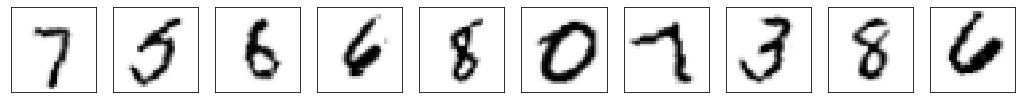

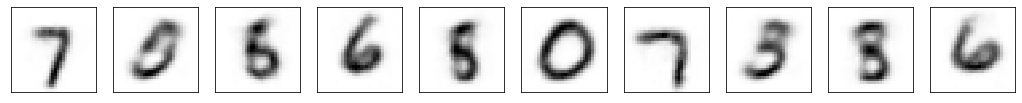

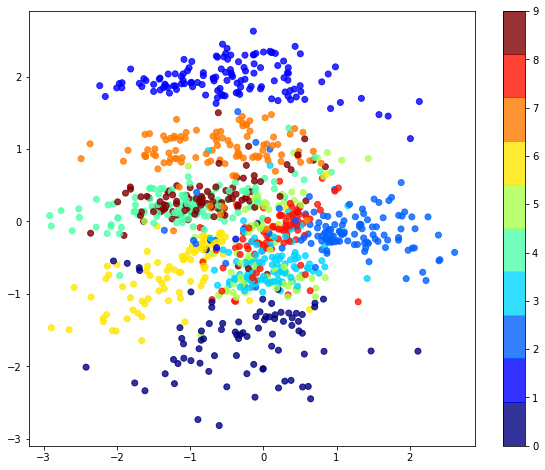

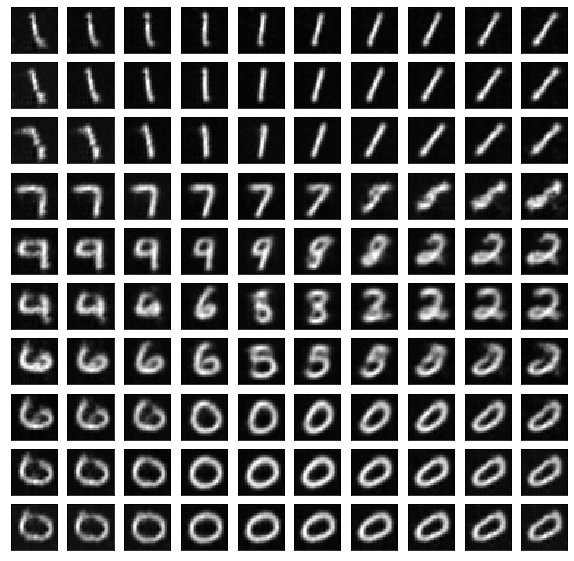

In [10]:
from IPython import display

# Backpropagation이 되도록 준비합니다.
model.train()

step = 0
stop = False
while(True):
    for batch_index, batch in enumerate(train_loader):

        # x : image (B, 1, 28, 28,)
        # t : class (B)
        x, t = batch

        x = x.cuda()
        t = t.cuda()

        # image를 model에 입력하고, 복원된 이미지 y와 
        # variational posterior q(x)의 parameter인 
        # mean과 log standard deviation을 출력합니다.
        model.zero_grad()
        y, z_mean, z_logstd = model(x)

        # Loss를 구하고 backpropagation을 통해 training을 진행합니다.
        loss = model.loss_function(x, y, z_mean, z_logstd)
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            print('step :', step, 'loss :', loss.item())

        if step % 100 == 0:
            display.clear_output()

            _x = x.data.cpu().numpy()
            _y = np.clip(y.data.cpu().numpy(), 0, 1)

            plt.figure(figsize=[18, 3])
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(_x[i, 0], cmap='Greys')
                plt.xticks([])
                plt.yticks([])
            plt.show()

            plt.figure(figsize=[18, 3])
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(_y[i, 0], cmap='Greys')
                plt.xticks([])
                plt.yticks([])
            plt.show()

            model.eval()
            for batch_index, batch in enumerate(test_loader):
                # x : image (B, 1, 28, 28,)
                # t : class (B)
                x, t = batch

                x = x.cuda()
                t = t.cuda()
                z_mean, _ = model.encoder(x)
                break

            _t = t.data.cpu().numpy()
            _z_mean = z_mean.data.cpu().numpy()

            plt.figure(figsize=[10, 8])
            plt.scatter(_z_mean[:, 0], _z_mean[:, 1], c=_t, cmap=discrete_cmap(10, 'jet'), alpha=0.8)
            plt.colorbar()
            plt.show()

            z_mesh = get_z_mesh().reshape([-1, 2])
            z_mesh = torch.from_numpy(z_mesh).float().cuda()
            y = model.decoder(z_mesh)
            _y = y.data.cpu().numpy()

            plot_x_mesh(_y)

        step += 1
        if step > 2000:
            stop = True
            break
            
    if stop:
        break